# forward simulation and inversion for a linear problem 

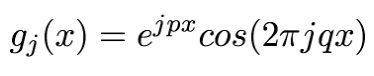

In [80]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import ipywidgets

In [2]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j * p * x) *
        np.cos(2 * np.pi * j * q * x)
    )

## build a mesh

In [3]:
n_cells = 100 
n_nodes = n_cells + 1
x_nodes = np.linspace(0, 1, n_nodes)

In [4]:
n_kernels = 5

p = -0.05
q = 0.1

j0 = 1
jN = 30 

j_values = np.linspace(j0, jN, n_kernels) 

In [5]:
G_nodes = np.zeros((n_nodes, n_kernels))

for j, jk in enumerate(j_values):
    G_nodes[:, j] = kernel_function(x_nodes, jk, p, q)

In [6]:
def get_G_nodes(x_nodes, n_kernels, j0=1, jN=30, p=-0.05, q=0.1): 
    j_values = np.linspace(j0, jN, n_kernels)
    n_nodes = len(x_nodes) 
    G_nodes = np.zeros((n_nodes, n_kernels))

    for j, jk in enumerate(j_values):
        G_nodes[:, j] = kernel_function(x_nodes, jk, p, q)

    return G_nodes

In [7]:
G2 = get_G_nodes(x_nodes, n_kernels=5) 

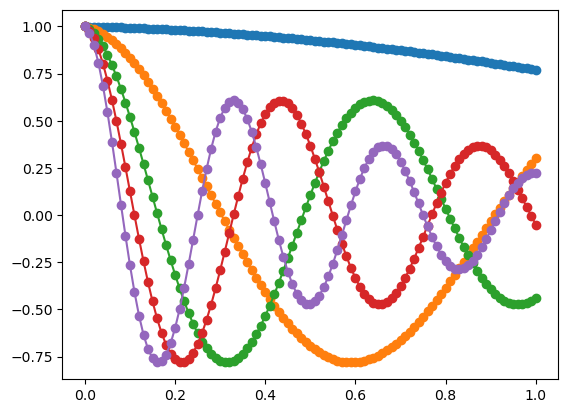

In [8]:
for i in range(n_kernels):
    plt.plot(x_nodes, G_nodes[:, i], color=f"C{i}")
    plt.plot(x_nodes, G2[:, i], "o", color=f"C{i}") 

## Build our model

In [9]:
# need to define x_centers 
x_centers  = 0.5*(x_nodes[:-1] + x_nodes[1:])

In [10]:
delta_x = np.diff(x_nodes)
x_centers2 = delta_x / 2 + x_nodes[:-1]

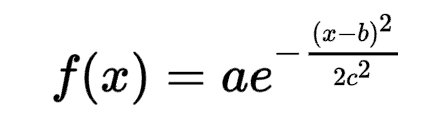

In [11]:
def get_model(
    x_centers,
    x_boxcar_min=0.2, x_boxcar_max=0.4, amplitude_boxcar=0.5,
    std_gaussian=0.05, amplitude_gaussian=1, center_gaussian = 0.7
): 
    """
    Function to get a model with a boxcar and a gaussian
    """
    model = np.zeros(n_cells)
    
    # define a boxcar
    inds_boxcar = (x_centers >= x_boxcar_min) & (x_centers <= x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar
    
    # define a gaussian
    gaussian = amplitude_gaussian * np.exp(-(x_centers-center_gaussian)**2 / (2*std_gaussian**2))
    model = model + gaussian

    return model


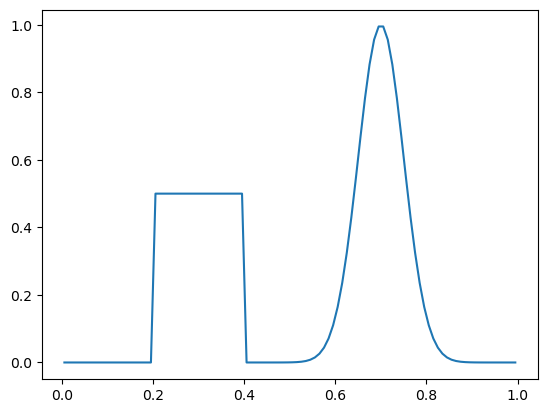

In [12]:
model = get_model(x_centers)
plt.plot(x_centers, model)

In [13]:
# the dense approach to building this matrix
# n_nodes_tmp = 5
# n_cells_tmp = n_nodes_tmp - 1

# Av = np.zeros((n_cells_tmp, n_nodes_tmp))

# for i in range(n_cells_tmp):
#     Av[i, i] = 0.5
#     Av[i, i+1] = 0.5

In [14]:
# array of nnodes filled with 0.5 
# av_entries = np.vstack(
#     [0.5*np.ones(n_nodes), 0.5*np.ones(n_nodes)]
# )
# Av = sp.spdiags(av_entries, [0, 1] , m=n_cells, n=n_nodes) 

In [15]:
# plt.spy(Av)
# plt.matshow(Av2.todense())

In [16]:
# diag_delta_x = sp.spdiags(delta_x, [0], m=n_cells, n=n_cells)

In [17]:
# G = (Av @ G_nodes).T @ diag_delta_x

In [18]:
# G.shape

In [19]:
def get_G(x_nodes, n_kernels, j0=1, jN=30, p=-0.05, q=0.1): 
    G_nodes = get_G_nodes(x_nodes, n_kernels=n_kernels, j0=j0, jN=jN, p=p, q=q)

    # Averaging matrix 
    av_entries = np.vstack(
        [0.5*np.ones(n_nodes), 0.5*np.ones(n_nodes)]
    )
    Av = sp.spdiags(av_entries, [0, 1] , m=n_cells, n=n_nodes) 

    delta_x = np.diff(x_nodes)
    diag_delta_x = sp.spdiags(delta_x, [0], m=n_cells, n=n_cells)

    G = (Av @ G_nodes).T @ diag_delta_x

    return G

In [20]:
n_kernels = 30
G = get_G(x_nodes, n_kernels)
data = G @ model #+ np.random.randn(n_kernels) * std_noise

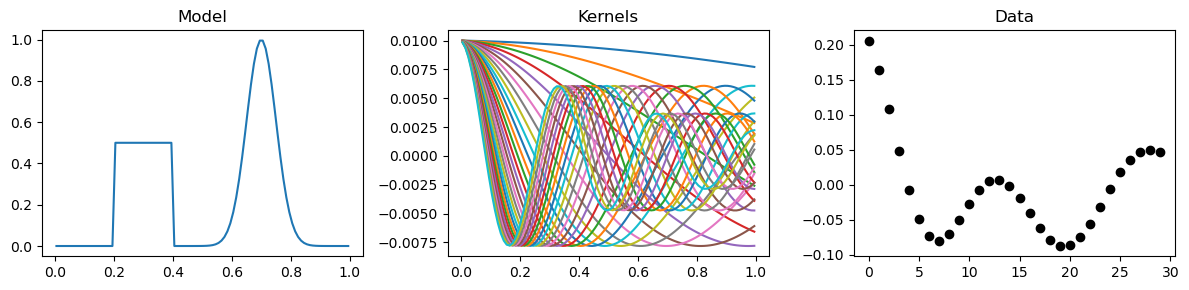

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(x_centers, model)
ax[0].set_title("Model")

ax[1].plot(x_centers, G.T)
ax[1].set_title("Kernels")

ax[2].plot(data, "o", color="k")
ax[2].set_title("Data")

plt.tight_layout()

In [22]:
n_kernels

30

In [23]:
G.shape

(30, 100)

In [24]:
Wd = sp.eye(n_kernels) 

In [25]:
A = (G.T @ Wd.T @ Wd @ G) #+ sp.eye(n_cells)
A.shape

(100, 100)

In [26]:
b = G.T @ Wd.T @ Wd @ data
b.shape

(100,)

In [27]:
m_recovered = np.linalg.solve(A, b)

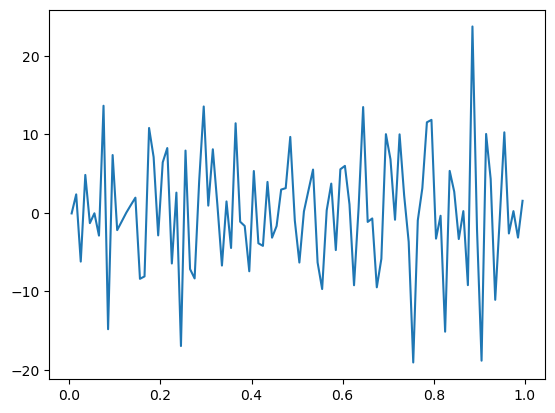

In [28]:
plt.plot(x_centers, m_recovered)

In [29]:
eigenvalues, eigenvectors = np.linalg.eig(A)

In [30]:
eigenvalues.shape

(100,)

/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/lindseyjh/miniforge3/envs/py311/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


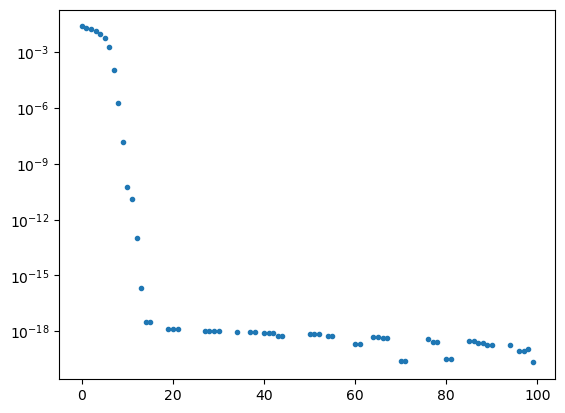

In [31]:
plt.semilogy(eigenvalues, ".")

# Add regularization

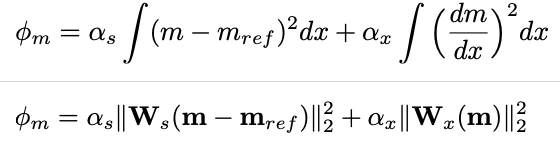

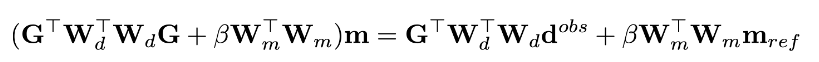

In [32]:
def estimate_m(
    x_nodes, dobs, G, beta, std, alpha_s=1, 
    # alpha_x, mref=0
): 
    # construct our data misfit term and components 
    n_kernels = G.shape[0]
    diagonal = 1/std * np.ones(n_kernels)
    Wd = sp.diags(diagonal, 0, shape=(n_kernels, n_kernels))

    # regularization -- need Ws, (Wx)
    delta_x = np.diff(x_nodes) 
    n_cells = len(delta_x) # G.shape[1]
    Ws = sp.diags(np.sqrt(delta_x), 0, shape=(n_cells, n_cells))
    Wm = alpha_s * Ws  # alpha_s * Ws + alpha_x * Wx

    # construct the system we will solve 
    H = (G.T @ Wd.T @ Wd @ G) + beta * Ws.T @ Ws
    rhs = G.T @ Wd.T @ Wd @ dobs  # TODO: update if we include a reference model

    # estimate m 
    m_recovered = np.linalg.solve(H, rhs)

    # compute dpred 
    dpred = G @ m_recovered

    # compute phid
    residual = dpred - dobs
    Wd_r = Wd @ residual 
    phid = Wd_r.T @ Wd_r # np.linalg.norm(Wd_r)**2 

    # compute phim
    Wm_m = Wm @ m_recovered  # TODO: (m_recovered - mref) 
    phim = Wm_m.T @ Wm_m 

    return m_recovered, dpred, phid, phim

In [48]:
# forward simulation
noise_level = 0.01
dobs = G @ model + noise_level * np.random.randn(n_kernels) # plus noise 

# inversion
beta = 1e3
std = noise_level
m_recovered, dpred, phid, phim = estimate_m(x_nodes, dobs, G, beta, std)

In [47]:
def plot_recovered_model(x_centers, model, m_recovered, G, dobs, dpred, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].plot(x_centers, model, label="true model")
    ax[0].plot(x_centers, m_recovered, label="recovered model") 
    ax[0].set_title("Model")
    ax[0].legend()
    
    ax[1].plot(x_centers, G.T)
    ax[1].set_title("Kernels")
    
    ax[2].plot(dobs, "o", color="k", label="dobs")
    ax[2].plot(dpred, "-", color="r", label="dpred")
    ax[2].set_title("Data")
    ax[2].legend()
    
    plt.tight_layout()

    return ax

array([<Axes: title={'center': 'Model'}>,
       <Axes: title={'center': 'Kernels'}>,
       <Axes: title={'center': 'Data'}>], dtype=object)

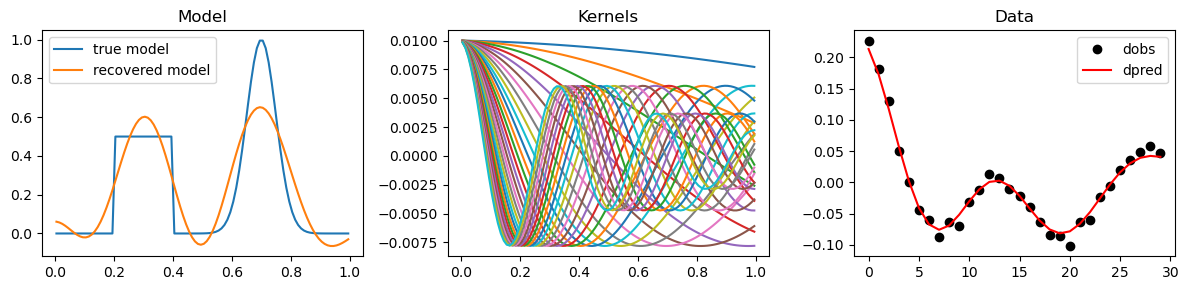

In [53]:
plot_recovered_model(x_centers, model, m_recovered, G, dobs, dpred)

In [68]:
# for loop where we try lots of betas 
def run_inversions(x_nodes, dobs, G, std, beta_min=-2, beta_max=5, n_beta=50): #alpha_s, alpha_x
    betas = np.logspace(beta_max, beta_min, n_beta) 
    
    M_recovered = np.zeros((n_cells, n_beta))
    D_pred = np.zeros((n_kernels, n_beta))
    phids = np.zeros(n_beta)
    phims = np.zeros(n_beta) 
    
    for i, beta in enumerate(betas): 
        mrec, dpred, phid, phim = estimate_m(x_nodes, dobs, G, beta, std)
        M_recovered[:, i] = mrec
        D_pred[:, i] = dpred
        phids[i] = phid
        phims[i] = phim
    return betas, M_recovered, D_pred, phids, phims

In [69]:
betas, M_recovered, D_pred, phids, phims = run_inversions(x_nodes, dobs, G, std)

In [67]:
M_recovered.shape

(100, 50)

In [70]:
def plot_tikhonov_curves(betas, phids, phims, iteration=0, n_kernels=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].semilogx(betas, phids) 
    ax[0].semilogx(betas[iteration], phids[iteration], "ro")
    
    if n_kernels is not None: 
        ax[0].semilogx(betas, n_kernels*np.ones_like(betas), "--k")
    ax[0].set_xlim([betas.max(), betas.min()])
    ax[0].set_xlabel("$\\beta$")
    ax[0].set_ylabel("$\\phi_d$")
    
    ax[1].semilogx(betas, phims) 
    ax[1].semilogx(betas[iteration], phims[iteration], "ro")
    ax[1].set_xlim([betas.max(), betas.min()])
    ax[1].set_xlabel("$\\beta$")
    ax[1].set_ylabel("$\\phi_m$")
    
    ax[2].plot(phims, phids)
    ax[2].plot(phims[iteration], phids[iteration], "ro")
    if n_kernels is not None:
        ax[2].semilogx(phims, n_kernels*np.ones_like(phims), "--k")
    ax[2].set_xlabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    
    # ax[0].set_ylim([-1, 200])
    plt.tight_layout()
    return ax 

array([<Axes: xlabel='$\\beta$', ylabel='$\\phi_d$'>,
       <Axes: xlabel='$\\beta$', ylabel='$\\phi_m$'>,
       <Axes: xlabel='$\\phi_m$', ylabel='$\\phi_d$'>], dtype=object)

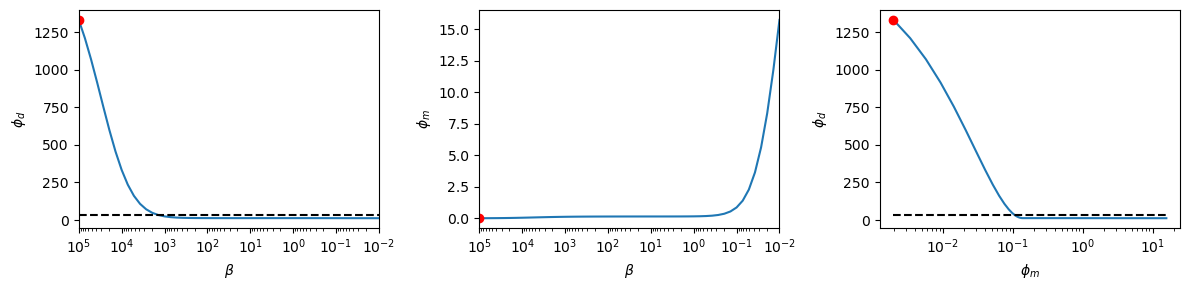

In [72]:
plot_tikhonov_curves(betas, phids, phims, n_kernels=n_kernels, iteration=0)

In [73]:
G.shape

(30, 100)

In [77]:
def plot_iteration(
    x_nodes, true_model, dobs, G, std, 
    iteration=0, 
    beta_min=-2, beta_max=5, n_beta=50,
    ax=None
): # alpha_s, alpha_x

    betas, M_recovered, D_pred, phids, phims = run_inversions(
        x_nodes, dobs, G, std, 
        beta_min=beta_min, beta_max=beta_max, n_beta=n_beta
    ) 
    
    # create a plot with 2 rows
    if ax is None: 
        fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    
    # top plots - model, data 
    m_recovered = M_recovered[:, iteration]
    dpred = D_pred[:, iteration]
    x_centers = x_nodes[0:-1] + np.diff(x_nodes)/2
    plot_recovered_model(
        x_centers, true_model, m_recovered, G, dobs, dpred,
        ax=ax[0, :]
    )
    
    # bottom plots - tikhonov curves 
    n_kernels = G.shape[0]
    plot_tikhonov_curves(
        betas, phids, phims, n_kernels=n_kernels, iteration=iteration,
        ax=ax[1, :]
    )

    return ax

array([[<Axes: title={'center': 'Model'}>,
        <Axes: title={'center': 'Kernels'}>,
        <Axes: title={'center': 'Data'}>],
       [<Axes: xlabel='$\\beta$', ylabel='$\\phi_d$'>,
        <Axes: xlabel='$\\beta$', ylabel='$\\phi_m$'>,
        <Axes: xlabel='$\\phi_m$', ylabel='$\\phi_d$'>]], dtype=object)

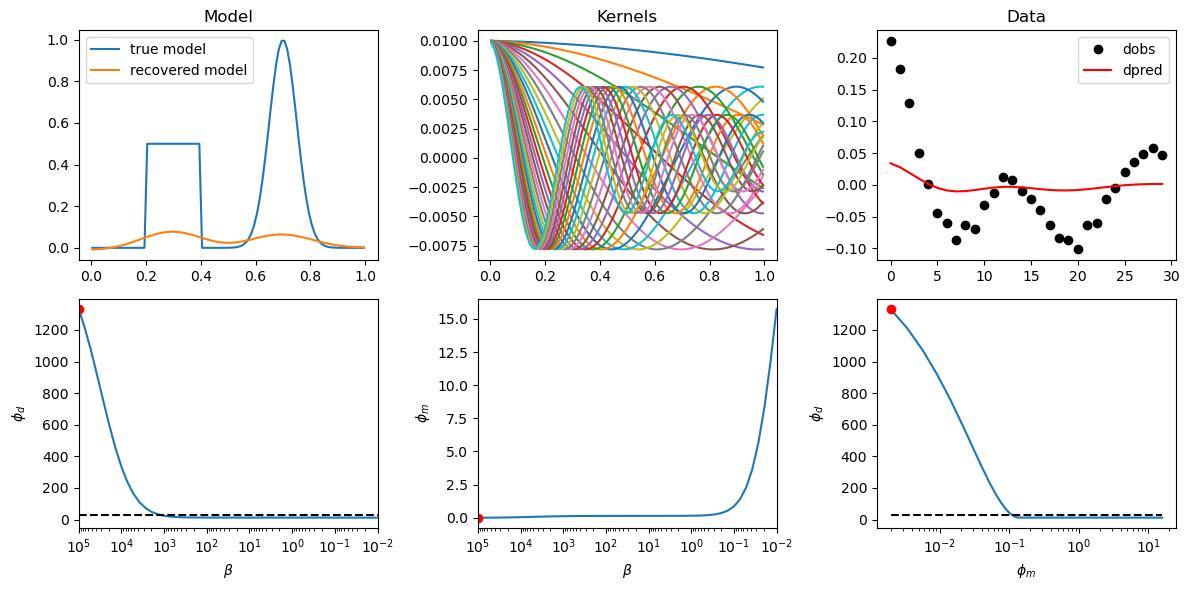

In [78]:
plot_iteration(
    x_nodes, model, dobs, G, std, 
    iteration=0, 
    # beta_min=-2, beta_max=5, n_beta=50,
)

In [82]:
n_beta = 50
beta_min=-2
beta_max=5
def plot_iteration_interactive(std, iteration):
    plot_iteration(
        x_nodes, model, dobs, G, std, 
        iteration, 
        beta_min=beta_min, 
        beta_max=beta_max, 
        n_beta=n_beta,
    )

In [81]:
noise_level

0.01

In [83]:
ipywidgets.interact(
    plot_iteration_interactive,
    std=ipywidgets.FloatText(value=noise_level),
    iteration=ipywidgets.IntSlider(min=0, max=n_beta-1, value=0)
)

interactive(children=(FloatText(value=0.01, description='std'), IntSlider(value=0, description='iteration', ma…

<function __main__.plot_iteration_interactive(std, iteration)>